In [96]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import pyarrow.parquet as pq   # For reading train_parquet file
import os
import numba 
from scipy.signal import find_peaks, argrelmax
import random

In [30]:
data_folder = '../../input'
os.listdir(data_folder)

['metadata_train.csv', 'train.parquet', 'VSB Power Line Fault Detection']

In [31]:
df_meta = pd.read_csv(data_folder + '/metadata_train.csv')

In [32]:
%%time
# Load Parquet file containing 800k signal measurements for each signal_id in df_meta

parq_data = pq.read_pandas(data_folder + '/train.parquet').to_pandas()

Wall time: 31.4 s


## Understanding Data
* **Information on meta_data and signal_data**
* **Interpretation of data distribution**
* **Review Visual patterns of fault(PD-partial discharge positive) and fault-free(PD-free) signals**  
* **Review peaks in sample signals**


### Information on meta_data and signal_data

In [33]:
df_meta.describe()

,signal_id,id_measurement,phase,target
count,8712.000000,8712.000000,8712.000000,8712.000000
mean,4355.500000,1451.500000,1.000000,0.060262
std,2515.082106,838.360658,0.816543,0.237985
min,0.000000,0.000000,0.000000,0.000000
25%,2177.750000,725.750000,0.000000,0.000000
50%,4355.500000,1451.500000,1.000000,0.000000
75%,6533.250000,2177.250000,2.000000,0.000000
max,8711.000000,2903.000000,2.000000,1.000000


In [34]:
df_meta.head()

,signal_id,id_measurement,phase,target
0,0,0,0,0
1,1,0,1,0
2,2,0,2,0
3,3,1,0,1
4,4,1,1,1


In [35]:
parq_data.shape

(800000, 8712)

In [36]:
col = [str(i) for i in range(5)]
parq_data[col].head()

,0,1,2,3,4
0,18,1,-19,-16,-5
1,18,0,-19,-17,-6
2,17,-1,-20,-17,-6
3,18,1,-19,-16,-5
4,18,0,-19,-16,-5


In [37]:
df_meta.corr()

,signal_id,id_measurement,phase,target
signal_id,1.000000,1.000000,0.000325,-0.023992
id_measurement,1.000000,1.000000,0.000000,-0.023993
phase,0.000325,0.000000,1.000000,0.001772
target,-0.023992,-0.023993,0.001772,1.000000


### Interpretation of data 
Understanding from above set of information
* Signal data (parq_data) contains 3 phase signal measurements.
* Each signal_id has 800k measurements in parq_data.
* parq_data has 3 phase (0, 1, 2) signal measurements for each of id_measurement. 
* Above table highlights that target (1- PD fault or 0- PD free) is independent of phase and id_measurement

In [38]:
# PD - Partial Discharge

PD_fault_mid = np.unique(df_meta.loc[df_meta.target == 1, 'id_measurement'].values)
PD_free_mid = np.unique(df_meta.loc[df_meta.target == 0, 'id_measurement'].values)
print(PD_fault_mid.shape, PD_fault_mid[:5], '\n', PD_free_mid.shape, PD_free_mid[:5])

(194,) [ 1 67 76 90 93] 
 (2748,) [0 2 3 4 5]


In [111]:
# Sample signal_id for understanding of signal patterns

fault_sid = df_meta.loc[df_meta.id_measurement.isin(PD_fault_mid), 'signal_id']
fault_free_sid = df_meta.loc[df_meta.id_measurement.isin(PD_free_mid), 'signal_id']

In [45]:
@numba.jit(nopython=True)
def flatiron(x, alpha=100., beta=1):
    """
    Flatten signal
    Source : https://www.kaggle.com/miklgr500/flatiron
    """
    new_x = np.zeros_like(x)
    zero = x[0]
    for i in range(1, len(x)):
        zero = zero*(alpha-beta)/alpha + beta*x[i]/alpha
        new_x[i] = x[i] - zero
    return new_x

In [46]:
def detect_peaks(sig2D, prominance=None, width=25) :
    peaks = []
    for i in range(sig2D.shape[1]) :
        (p, _) = find_peaks(sig2D[i], prominence=prominance, width=width)
        peaks.append(p)
    return peaks

In [113]:
type(fault_sid)

pandas.core.series.Series

In [140]:
# Plot 3 phase PD fault signals before flatten

sids = fault_sid.sample(3,random_state=10)
sample = parq_data[map(str, sids)]
prominence, distance, cols = None, 100, sample.columns

flat_sample = []
pks_idx = []
trough_idx = []
for i, col in enumerate(cols):
    flat_sample.append(flatiron(sample[col].values.astype(np.float)))
    (idx, _) = find_peaks(flat_sample[i], prominence=prominence, distance=distance)
    pks_idx.append(idx)
    (idx, _) = find_peaks(flat_sample[i] * -1, prominence=prominence, distance=distance)
    trough_idx.append(idx)


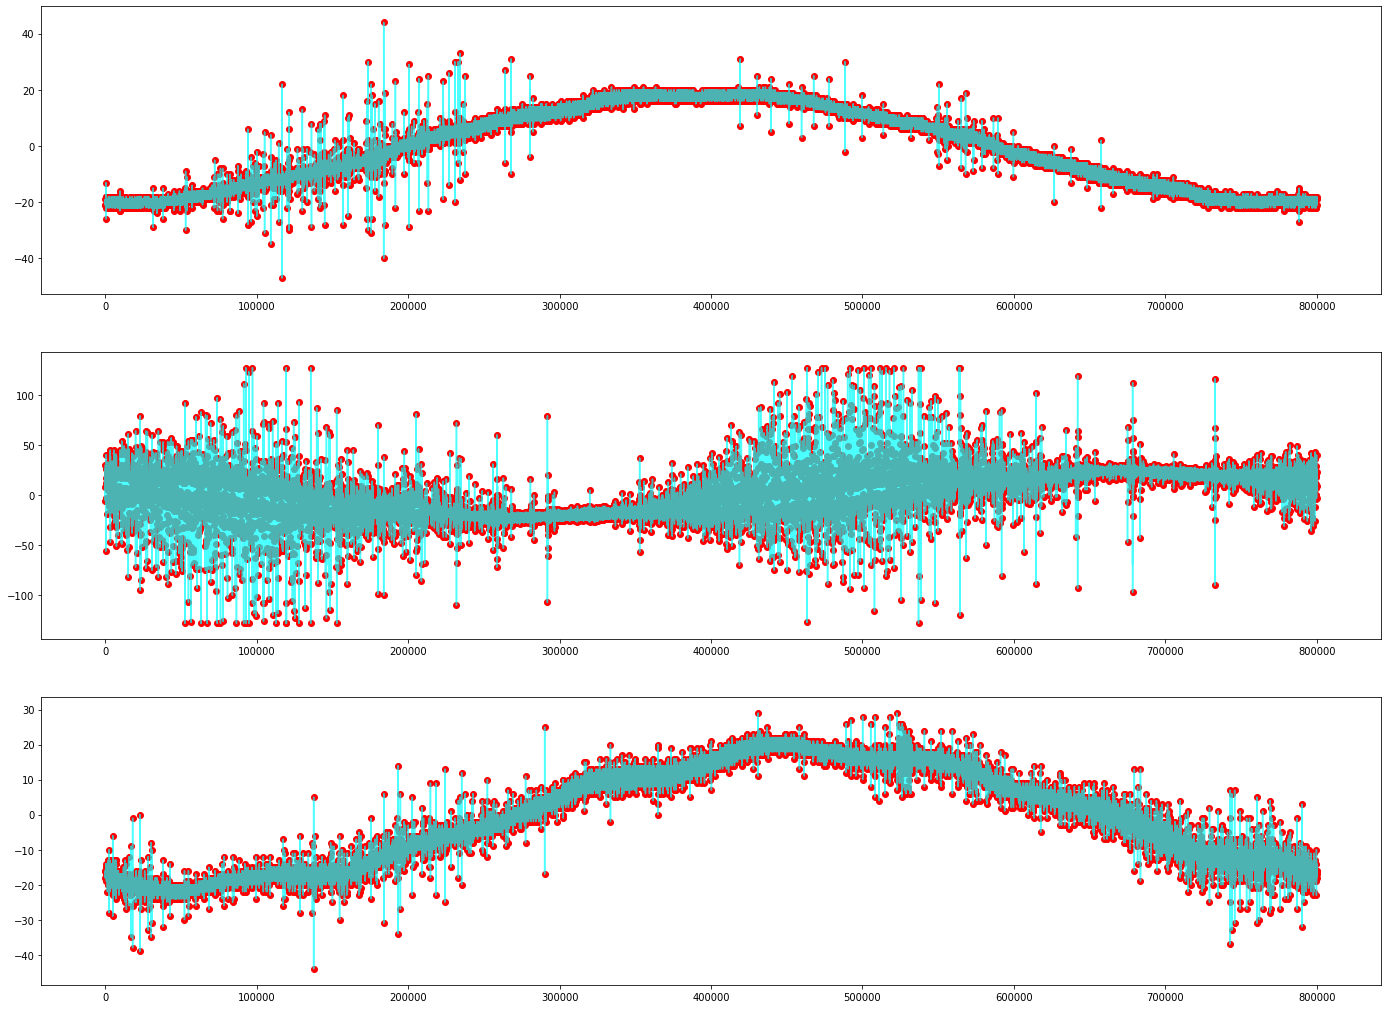

In [135]:
# Plot 3 phase PD fault signals before flatten

fig, axs = plt.subplots(3,1, figsize=(24,18))
for i, (col, ax) in enumerate(zip(cols, axs)) :
    ax.plot(sample[col], color='aqua', alpha=0.7)
    (pks_idx, _) = find_peaks(flat_sample[i], prominence=prominence, distance=distance)
    ax.scatter(pks_idx, sample[col][pks_idx], color='red')
    (pks_idx, _) = find_peaks(flat_sample[i] * -1, prominence=prominence, distance=distance)
    ax.scatter(pks_idx, sample[col][pks_idx], color='red')
plt.show()
    

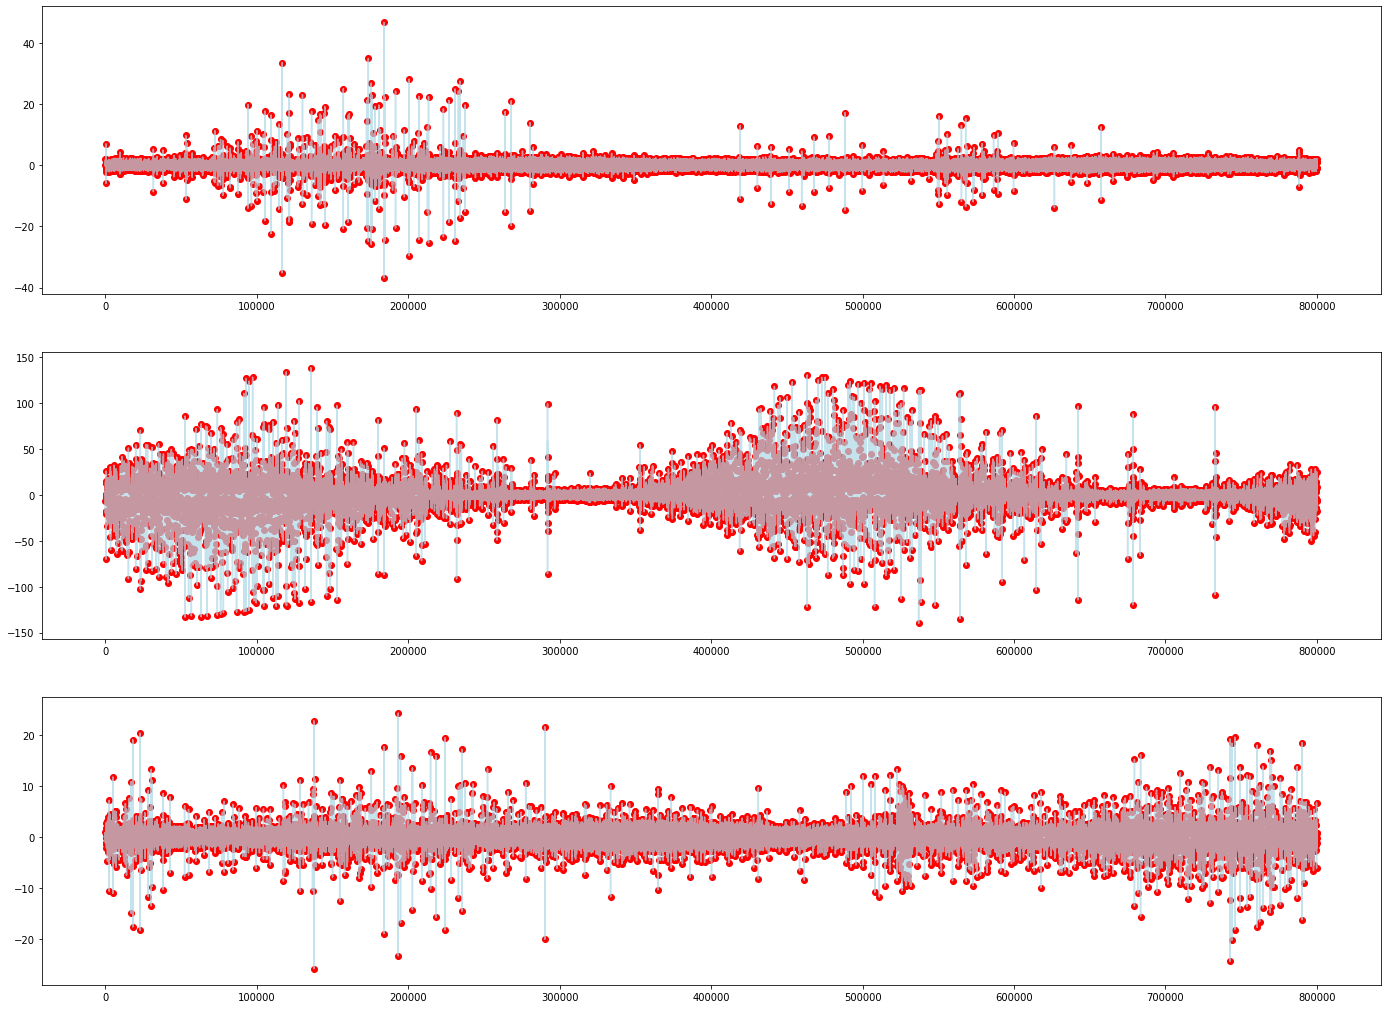

In [141]:
# Plot 3 phase PD fault signals after flatten

fig, axs = plt.subplots(3,1, figsize=(24,18))
for i, (col, ax) in enumerate(zip(cols, axs)) :
    ax.plot(flat_sample[i], color='lightblue', alpha=0.7)
    ax.scatter(pks_idx[i], flat_sample[i][pks_idx[i]], color='red')
    ax.scatter(trough_idx[i], flat_sample[i][trough_idx[i]], color='red')
plt.show()

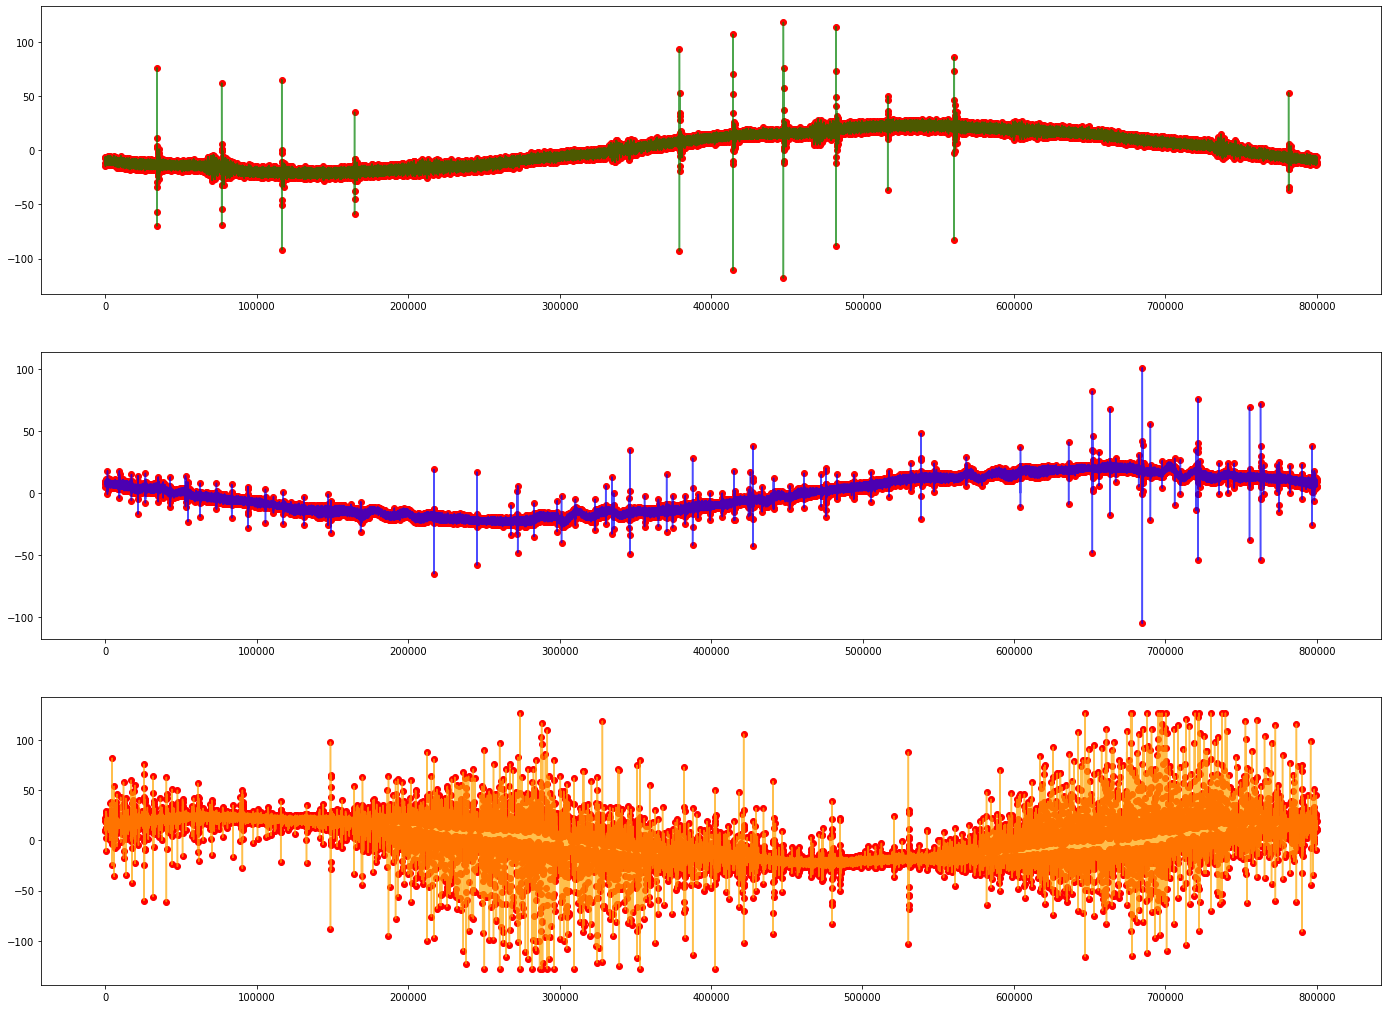

In [92]:
# Plot 3 phase PD fault signals before flatten

sids = [10, 4200, 4225]
sample = parq_data[map(str, sids)]
prominence, distance, cols = None, 50, sample.columns
colors = ['green', 'blue', 'orange']

fig, axs = plt.subplots(3,1, figsize=(24,18))
for i, (col, ax, color) in enumerate(zip(cols, axs, colors)) :
    ax.plot(sample[col], color=color, alpha=0.7)
    flat_sample = flatiron(sample[col].values.astype(np.float))
    pks_idx = argrelmax(flat_sample, order=distance)[0]
    ax.scatter(pks_idx, sample[col][pks_idx], color='red')
    pks_idx = argrelmax(flat_sample * -1, order=distance)[0]
    ax.scatter(pks_idx, sample[col][pks_idx], color='red')
plt.show()

In [50]:
# Flatten the sample 
flat_sample = flatiron(PD_fault_sample.values.astype(np.float))

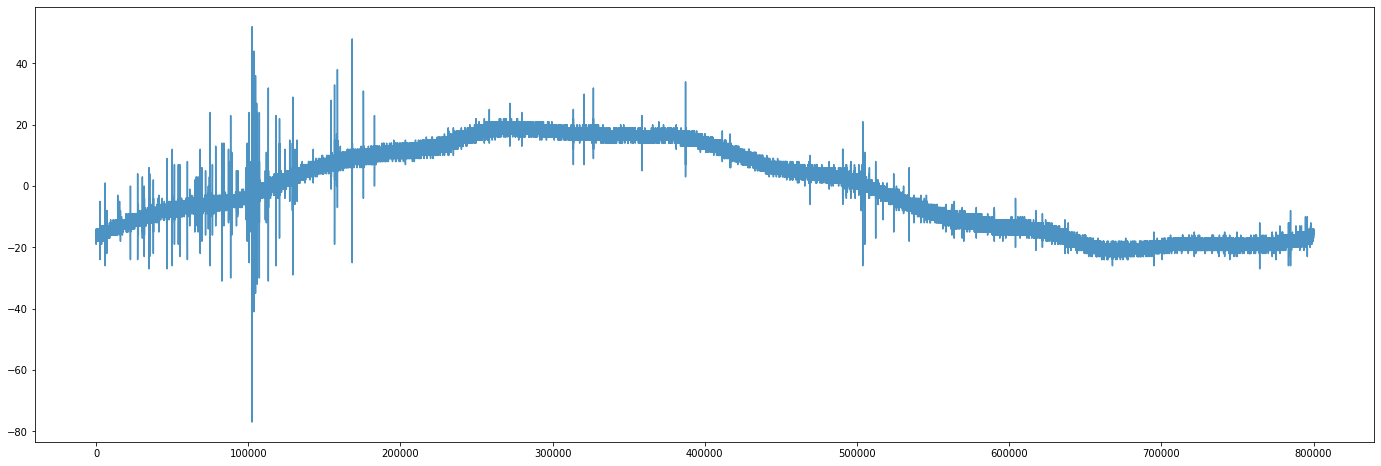

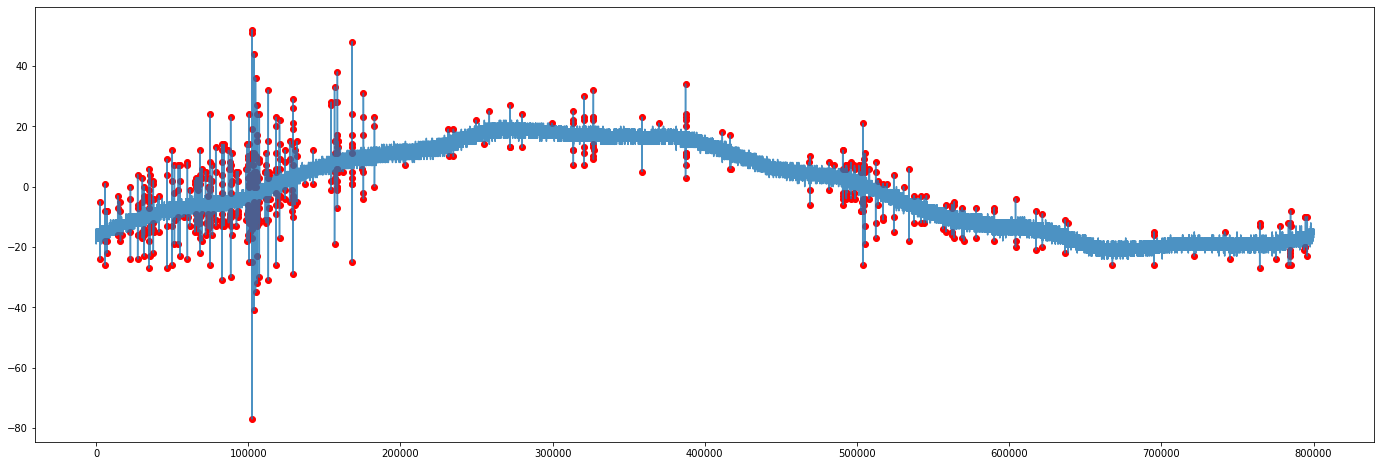

In [51]:
# Plot one of the 3 phase of a PD fault signal with its peaks and troughs

fig, ax = plt.subplots(1,1, figsize(24,8))
cols = PD_fault_sample.columns
plt.plot(PD_fault_sample[cols[0]], alpha=0.8);
plt.show()

prominance = 8
plt.figure(figsize=(24, 8))
plt.plot(PD_fault_sample[cols[0]], alpha=0.8);
(peaks_idx, _) = find_peaks(flat_sample[:,0], prominence=prominance)
plt.scatter(peaks_idx, PD_fault_sample[cols[0]][peaks_idx], color='red')
(peaks_idx, _) = find_peaks(flat_sample[:,0] * -1, prominence=prominance)
plt.scatter(peaks_idx, PD_fault_sample[cols[0]][peaks_idx], color='red')
plt.show()

In [52]:
flat_sample[:,0][50:55]

array([1.10327881, 1.09224602, 1.08132356, 0.08051033, 0.07970522])

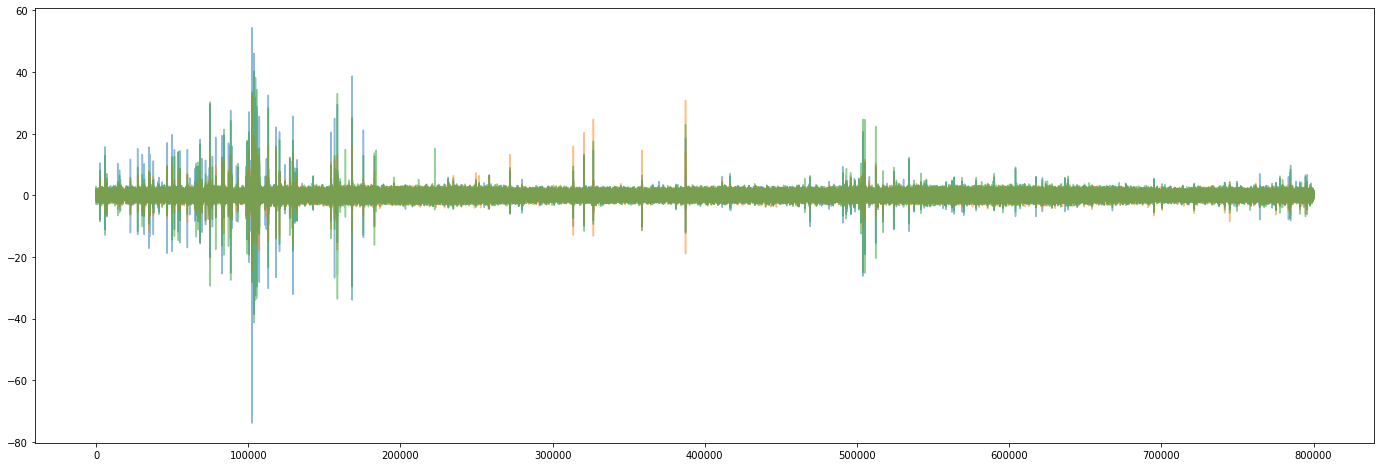

In [53]:
# Plot 3 phase PD fault signals after flattern

plt.figure(figsize=(24, 8))
plt.plot(flat_sample, alpha=0.5);

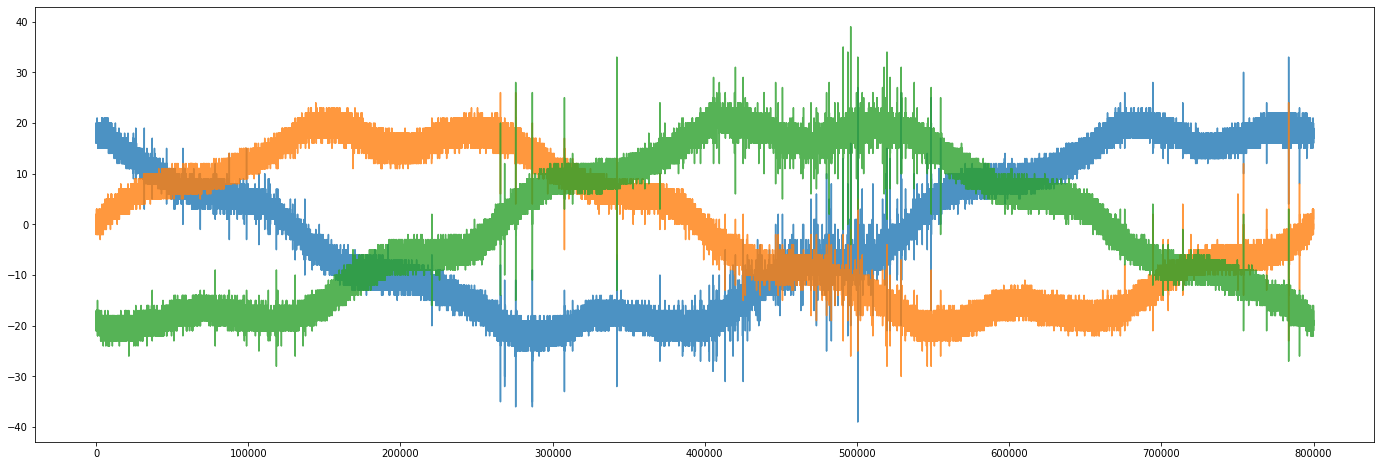

In [54]:
# Plot 3 phase PD free signals before flatten

plt.figure(figsize=(24, 8))
plt.plot(PD_free_sample, alpha=0.8);

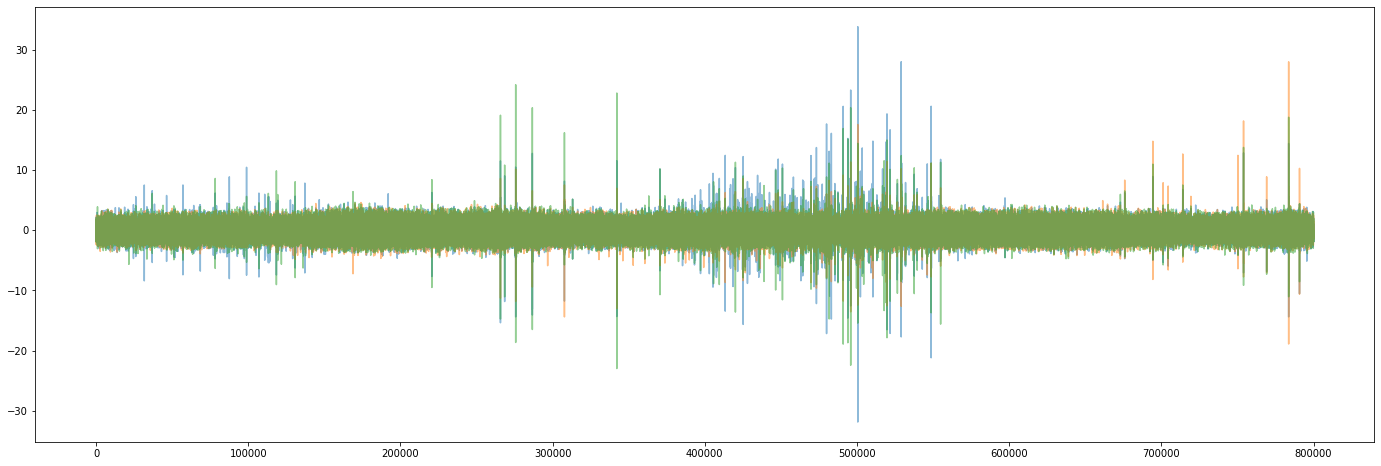

In [55]:
# Plot 3 phase PD free signals after flattern
sample = flatiron(PD_free_sample.values.astype(np.float))
plt.figure(figsize=(24, 8))
plt.plot(sample, alpha=0.5);

In [56]:
cols = PD_fault_sample.columns
PD_fault_sample[cols[0]][:5]

0   -16
1   -17
2   -17
3   -16
4   -16
Name: 3, dtype: int8

In [57]:
sample.shape

(800000, 3)